In [1]:
# python 3 version
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

def rk4(x,t,tau,derivsRK,param):
    """
    ##  Runge-Kutta integrator (4th order)
    ## Input arguments -
    ##   x = current value of dependent variable
    ##   t = independent variable (usually time)
    ##   tau = step size (usually timestep)
    ##   derivsRK = right hand side of the ODE; derivsRK is the
    ##             name of the function which returns dx/dt
    ##             Calling format derivsRK(x,t).
    ## Output arguments -
    ##   xout = new value of x after a step of size tau
    """
    half_tau = 0.5*tau
    F1 = derivsRK(x,t,param)
    t_half = t + half_tau
    xtemp = x + half_tau*F1
    F2 = derivsRK(xtemp,t_half,param)
    xtemp = x + half_tau*F2
    F3 = derivsRK(xtemp,t_half,param)
    t_full = t + tau
    xtemp = x + tau*F3
    F4 = derivsRK(xtemp,t_full,param)
    xout = x + tau/6.*(F1 + F4 + 2.*(F2+F3))
    return xout


def rka(x,t,tau,err,derivsRK,param):
    """
    ## Adaptive Runge-Kutta routine
    ## Inputs
    ##   x          Current value of the dependent variable
    ##   t          Independent variable (usually time)
    ##   tau        Step size (usually time step)
    ##   err        Desired fractional local truncation error
    ##   derivsRK   Right hand side of the ODE; derivsRK is the
    ##              name of the function which returns dx/dt
    ##              Calling format derivsRK(x,t).
    ## Outputs
    ##   xSmall     New value of the dependent variable
    ##   t          New value of the independent variable
    ##   tau        Suggested step size for next call to rka
    """
    # Set initial variables
    tSave = t;  xSave = x    # Save initial values
    safe1 = .9;  safe2 = 4.  # Safety factors
    eps = np.spacing(1) # smallest value

    # Loop over maximum number of attempts to satisfy error bound
    maxTry = 100

    for iTry in range(1,maxTry):
	
        # Take the two small time steps
        half_tau = 0.5 * tau
        xTemp = rk4(xSave,tSave,half_tau,derivsRK,param)
        t = tSave + half_tau
        xSmall = rk4(xTemp,t,half_tau,derivsRK,param)
          
        # Take the single big time step
        t = tSave + tau
        xBig = rk4(xSave,tSave,tau,derivsRK,param)
          
        # Compute the estimated truncation error
        scale = err * (np.abs(xSmall) + np.abs(xBig))/2.
        xDiff = xSmall - xBig
        errorRatio = np.max( [np.abs(xDiff)/(scale + eps)] )
        
        #print safe1,tau,errorRatio
          
        # Estimate news tau value (including safety factors)
        tau_old = tau
        
        tau = safe1*tau_old*errorRatio**(-0.20)
        tau = np.max([tau,tau_old/safe2])
        tau = np.min([tau,safe2*tau_old])
  
        # If error is acceptable, return computed values
        if errorRatio < 1 : 
            xSmall = xSmall 
            return xSmall, t, tau  
    # Issue error message if error bound never satisfied
    print ('ERROR: Adaptive Runge-Kutta routine failed')
    return



def lorzrk(s,t,param):
    """
    #  Returns right-hand side of Lorenz model ODEs
    #  Inputs
    #    s      State vector [x y z]
    #    t      Time (not used)
    #    param  Parameters [r sigma b]
    #  Output
    #    deriv  Derivatives [dx/dt dy/dt dz/dt]
    """
    r = param[0]
    sigma = param[1]
    b = param[2]
    #* For clarity, unravel input vectors
    x = s[0]; y = s[1]; z = s[2]
    #* Return the derivatives [dx/dt dy/dt dz/dt]
    deriv = np.zeros(3)
    deriv[0] = sigma*(y-x)
    deriv[1] = r*x - y - x*z
    deriv[2] = x*y - b*z
    return deriv



def lorenz_data_gen(init_x,init_y,init_z,init_r):
    """
    Generates data needed to plot the results 
    of lorentz.py using rk4 as in Ch3 ex 25

    Parameters
    ----------
    init_x : Float
        Inital x value.
    init_y : Float
        Initial y value.
    init_z : Float
        Inital z value.
    r : float
        Lorenz model parameter.


    Returns
    -------
    xplot : Numpy array
        Array of x-values used to plot.
    yplot : Numpy array
        Array of y-values used to plot.
    zplot : Numpy array
        Array of z-values used to plot.
    tplot : Numpy array
        Array of time-values used to plot.

    """
    # Set initial state x,y,z and parameters r,sigma,b
    sxin,syin,szin = init_x,init_y,init_z
    state = np.zeros(3)
    state[0] = float(sxin); state[1]  = float(syin); state[2]  = float(szin)
    
    
    r = init_r
    sigma = 10   # Parameter sigma
    b = 8./3.     # Parameter b
    param = np.array([r, sigma, b])  # Vector of parameters passed to rka
    tau = .02       # Timestep from lorenz with n=500
    #err = 1.e-3   # Error tolerance
    
    # Loop over the desired number of steps
    time = 0
    nstep = 500
    # initialize arrays
    tplot=np.array([]); tauplot=np.array([])
    xplot=np.array([]); yplot=np.array([]); zplot=np.array([])
    
    for istep in range(0,nstep):
        # Record values for plotting
        x = state[0]
        y = state[1] 
        z = state[2]
        tplot = np.append(tplot,time)
        tauplot = np.append(tauplot,tau)
        xplot = np.append(xplot,x)
        yplot = np.append(yplot,y)
        zplot = np.append(zplot,z)
        #if( istep%50 ==0 ):
          #print('Finished %d steps out of %d '%(istep,nstep))
        # Find new state using Runge-Kutta4
        state = rk4(state,time,tau,lorzrk,param)
        time += tau
    """
    # Graph the time series x(t)
    plt.figure(1) 
    plt.clf()  # Clear figure 1 window and bring forward
    plt.plot(tplot,xplot,'-')
    plt.xlabel('Time');  plt.ylabel('x(t)')
    plt.title('Lorenz model time series')
    # plt.show()
    
    # Graph the x,y,z phase space trajectory
    
    """
    fig=plt.figure(2)
    ax=p3.Axes3D(fig)
    
    ax.plot3D(xplot,yplot,zplot)
    if init_y == 0:
        print("1")
        ax.scatter3D(0,0,0,color='red')
    elif init_y == np.sqrt(b*(r-1)):
        print('2')
        ax.scatter3D(np.sqrt(b*(r-1)),np.sqrt(b*(r-1)),r-1,color='red')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.grid(True)
    # title('Lorenz model phase space')
    #ax.set_aspect('equal')
    plt.show()
    #"""
    return xplot,yplot,zplot,tplot

1


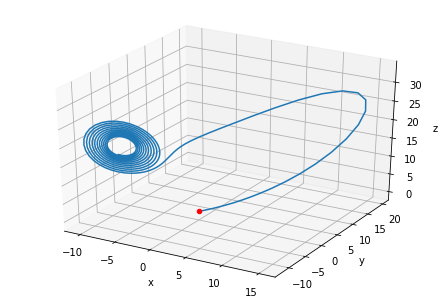

2


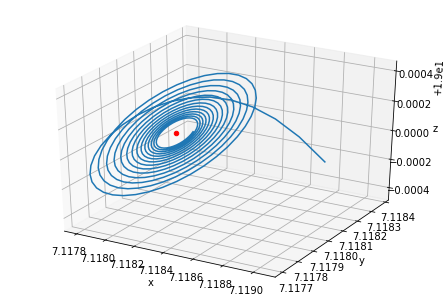

In [2]:
    
    init_x,init_y,init_z,init_r = 0.001,0,0,20
    xplot,yplot,zplot,tplot = lorenz_data_gen(init_x,init_y,init_z,init_r)
    
    r = 20
    sigma = 10
    b = 8/3
    
    init_x,init_y,init_z,init_r = np.sqrt(b*(r-1))+.001,np.sqrt(b*(r-1)),r-1,20
    xplot,yplot,zplot,tplot = lorenz_data_gen(init_x,init_y,init_z,init_r)